In [1]:
#환경을 구성해줍니다

import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


# [E4] 네이버 영화리뷰 감상 분석

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print(train_data.isnull().values.any())
#데이터 안에 비어있는 부분이 있는지 확인해줍니다. 각 리뷰별 길이가 다르기 때문에 트레인 데이터 안에는 빈 데이터들이 존재합니다.
#아래에서 제거해줍니다.

True


In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#토큰화 후 불용어들은 필요한 의미값을 지니지 않기 때문에 제거해줍니다.

tokenized_data = []
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    #트레인 데이터 안의 word갯수는 10000개. 
    #트레인 데이터 안의 자료들을 각각 불러와 토큰화 한 후 
    #임시적으로 temp  X 안에 넣어줬다가 스탑워드를 제거한 후 X_train데이터 안에 넣어주는 과정을 반복합니다.

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


# 3) 모델구성을 위한 데이터 분석 및 가공

In [7]:
#데이터셋 내 문장 길이 분포
#적절한 최대 문장 길이 지정
#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
#패드를 넣어줘 전체 문장 길이를 통일해줍니다.

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


노드에 따르면 rnn학습시 뒷부분을 pad로 채우는 것 보다는 앞부분을 pad로 채우는 쪽이 더 효율적이기 때문에    
```padding='post'```를 ```padding='pre'```로 변경해줍니다. rnn은 입력데이터가 순차적으로 처리되기 때문입니다.

# 4) 모델구성 및 validation set 구성

In [11]:
# validation set 10000건을 분리해줍니다. 여기의 값들도 하이퍼파라미터이기 때문에 조정이 필요합니다
x_val = X_train[:100000]   
y_val = y_train[:100000]
partial_X_train = X_train[100000:]  
partial_y_train = y_train[100000:]

In [12]:
vocab_size = 10000  
word_vector_dim = 4   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


# 5) 모델 훈련 개시

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
91/91 [==============================] - 4s 26ms/step - loss: 0.6906 - accuracy: 0.5562 - val_loss: 0.6344 - val_accuracy: 0.7387
Epoch 2/3
91/91 [==============================] - 2s 18ms/step - loss: 0.5711 - accuracy: 0.7739 - val_loss: 0.4566 - val_accuracy: 0.8156
Epoch 3/3
91/91 [==============================] - 2s 18ms/step - loss: 0.4156 - accuracy: 0.8342 - val_loss: 0.3950 - val_accuracy: 0.8315


## 하이퍼파라미터 조정  

- **word vector dim**
무슨 값일까 궁금해서 서치해봤더니. ```"Word Vector Dimension" is the dimension of the vector that you have trained with the training document. ... As it sounds, more dimension means heavier computation. However, if we set the dimension too low, then there is not much vector space to capture the information that the entire training document contains.``` 라는 답을 얻을 수 있었다. 값이 너무 높으면 연산을 하는 시간이 길어지고 값이 낮으면 트레이닝 데이터가 포함할 수 있는 정보의 양이 적어진다. 노드에서는 4정도로 제시해주었으나 호기심에 400까지 올려보니 학습시간이 한 Epoch당 13s로 길어졌다. 이후에 Word2vex을 활용하여 임베딩 작업을 할 예정이라 다시 4로 낮추었다.   
- **Epoch** 
처음에는 10회 정도로 잡아주었지만 loss, Accuracy 그래프를 보니 3-4회부터 오버피팅이 발생하고 있기에 값을 낮춰주었다.

# 6) Loss, Accuracy 그래프 시각화


In [14]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

#테스트 데이터로 돌려본 결과 정확도는 0.8237이다. 이 수치를 뒤에서 word2vec을 활용해 높혀보려한다.

1537/1537 - 2s - loss: 0.3999 - accuracy: 0.8291
[0.3999294638633728, 0.8290985822677612]


In [15]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


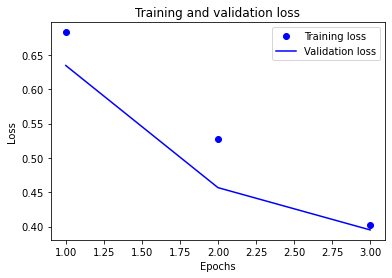

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

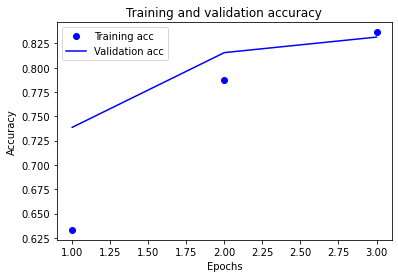

In [17]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   

(10000, 4)


In [19]:
import os
from gensim import models
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = models.Word2Vec.load(word2vec_path)

노드 상의 코드로 word2vec을 불러왔더니 유니코드 에러가 떴다.     
```ignore unicode error```로도 해결되지 않아 도움을 얻어 한국어 word2vec을 ko_model이라는 변수로 불러올 수 있었다.   
그 때문에 아래의 변수 이름들을 ko_model로 수정해주었다.

In [20]:
ko_model.similar_by_word("신나")

#word2vec의 비슷한 단어 찾기로 불러온 "신나". '재미있', '쿨하' 등 비슷한 단어들이 불려온 걸 확인할 수 있다.

/home/aiffel-dj57/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('흥겹', 0.6708460450172424),
 ('즐겁', 0.6107513904571533),
 ('힘차', 0.6027691960334778),
 ('차분', 0.595890462398529),
 ('재밌', 0.5955585241317749),
 ('재미있', 0.5918996930122375),
 ('애절', 0.5895642638206482),
 ('웃기', 0.5771744251251221),
 ('멋지', 0.5745470523834229),
 ('쿨하', 0.5625264644622803)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [21]:
import numpy as np
vocab_size = 10000    # 
word_vector_dim = 200  # 워드 벡터의 차원수를 300에서 200으로 수정해줬다.

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj57/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/home/aiffel-dj57/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


### 아래 주석처리는 활용해 본 모델들이다.

위에서 embedding matrix에 카피한 임베딩을 활용하기 위해   
``` 
model.add(keras.layers.Embedding(vocab_size, 
                                word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
                                 
                                 
```

라는 코드를 추가해서 활용해주었다.   
각 모델들의 하이퍼파라미터를 조절해봐도 눈에 띄게 성능이 개선되는 모델은 없었다.
검색해보니 LSTM이 흔히 가장 많이 사용되는 모델이라는 말이 있어 LSTM을 활용하기로 했다.

In [22]:
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
#word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  
#model.summary()

In [23]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.Conv1D(64, 7, activation='relu'))
#model.add(keras.layers.MaxPooling1D(5))
#model.add(keras.layers.Conv1D(128, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

#model.summary()

In [24]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(64))  
model.add(keras.layers.Dense(6, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 2,169,229
Trainable params: 2,169,229
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
91/91 [==============================] - 22s 234ms/step - loss: 0.6078 - accuracy: 0.6426 - val_loss: 0.4438 - val_accuracy: 0.7945
Epoch 2/3
91/91 [==============================] - 21s 231ms/step - loss: 0.4083 - accuracy: 0.8156 - val_loss: 0.3819 - val_accuracy: 0.8301
Epoch 3/3
91/91 [==============================] - 21s 231ms/step - loss: 0.3331 - accuracy: 0.8557 - val_loss: 0.3621 - val_accuracy: 0.8404


In [26]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


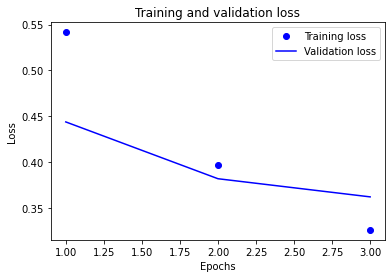

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Epoch 3회부터 오버피팅이 발생하는 것을 확인할 수 있다.

In [28]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 9s - loss: 0.3690 - accuracy: 0.8372
[0.36903905868530273, 0.8371544480323792]


## 하이퍼파라미터 조정  

- **word vector dim**
다른 값을 넣고 실행해 보았는데 행렬곱이 불가능하다는 에러가 떴다. 200으로 수정해주었다 
- **Epoch** 
5회 정도로 잡아주었지만 그래프를 보니 3회부터 오버피팅이 발생하고 있기에 값을 낮춰주었다.
- **PAD**
post로 지정했던 패딩의 위치를 pre로 수정해주었다,
- **validation set 지정**
트레인셋과 테스트셋에 들어가는 자료의 비율을 수정해보았다.
- **LSTM값 지정**
model.add(keras.layers.LSTM(64))          <=  128까지 넣어보았으나 속도만 느려질 뿐 accuracy에는 변화가 없었다.
model.add(keras.layers.Dense(32, activation='relu'))


# 후기   
처음으로 실시한 자연어처리 과정이라 그런가 쉽지 않았다. 그리고 영상보다 처리속도가 빠를거라 생각했는데 그렇지도 않은 것 같다.   
정확도를 올리기 위해 영상물보다 필요한 자료의 양이 많은걸까.

## 배운것
**감정분석의 유용성** : 단어가 가지고 있는 의미값. 감정분석을 실시하는 이유. 기계학습 기반 접근법과 감성사전 기반 접근법. 그 둘의 차이.    
**임베딩이란 무엇인가** : 자연어에 벡터 값을 할당하는 과정. 컴퓨터가 자연어를 처리할 수 있더록 만들어주는 전처리 과정에 해당    
**프리트레인 + 파인튜닝** : word2vec 말뭉치를 활용한 실습.     
                     (이론에 따르면 5%정도 정확도가 향상되어야 하는데 왜 내 실습에서는 별 차이가 없는지 잘 모르겠다.)    
                    
 **``<PAD>``활용** : PAD에는 0이 맵핑되어 있다. 활용하는 모델에 따라 패드를 앞에 채워넣느냐 뒤에 채워넣느냐에 따라 결과값이 달라진다.                     
## 어려운 것
정확도를 개선하기 위해 하이퍼파라미터들을 어떻게 활용해야할지 아직 감이 오지 않는다.    
나름 개선을 위해 바꾼 수치들이 오히려 accuracy를 낮추기도 했다.
